## Practice: Nonlinear control
This practice shows the implementation of:
- inverse dynamics control
- sliding mode control under parametric uncertainty and external disturbance.

In [1]:
import mujoco
import mediapy as media
import numpy as np 
renderer = None

import matplotlib.pyplot as plt

In [3]:
model = mujoco.MjModel.from_xml_path("kuka_iiwa_14/scene.xml")
data = mujoco.MjData(model)
if renderer is None:
    renderer = mujoco.Renderer(model, width=800, height=600)

In [4]:
class ActuatorMotor:
    def __init__(self, torque_range = [-100,100]) -> None:
        self.range = torque_range
        self.dyn = np.array([1, 0, 0])
        self.gain = np.array([1, 0, 0])
        self.bias = np.array([0, 0, 0])

    def __repr__(self) -> str:
        return f"ActuatorMotor(dyn={self.dyn}, gain={self.gain}, bias={self.bias})"
 
def update_actuator(model, actuator_id, actuator):
    """
    Update actuator in model
    model - mujoco.MjModel
    actuator_id - int or str (name) (for reference see, named access to model elements)
    actuator - ActuatorMotor, ActuatorPosition, ActuatorVelocity
    """
    model.actuator(actuator_id).dynprm = np.zeros(len(model.actuator(actuator_id).dynprm))
    model.actuator(actuator_id).gainprm = np.zeros(len(model.actuator(actuator_id).gainprm))
    model.actuator(actuator_id).biasprm = np.zeros(len(model.actuator(actuator_id).biasprm))
    model.actuator(actuator_id).ctrlrange = actuator.range 
    model.actuator(actuator_id).dynprm[:3] = actuator.dyn
    model.actuator(actuator_id).gainprm[:3] = actuator.gain
    model.actuator(actuator_id).biasprm[:3] = actuator.bias

In [5]:
nv = model.nv # number of DoFs

In [6]:
mujoco.mj_inverse(model, data) # invokes computing of inverse dynamics
combined_force = data.qfrc_inverse.copy() # the main output of inverse dynamics. It equals the sum of external and actuation forces.
print('Inertia matrix in a row form:\n', data.qM)
print('\n Combined force:\n', combined_force)

Inertia matrix in a row form:
 [ 7.11157945e-02  5.17957425e+00  5.65211180e-02  3.14298230e-02
  7.22564180e-02  3.14298230e-02  8.74088258e-01 -2.68313180e-02
 -1.91087086e+00 -2.68313180e-02  1.06338230e-02 -1.88583180e-02
  1.06338230e-02  4.94259180e-02  1.06338230e-02  1.79418480e-02
 -4.32000000e-07 -6.68538480e-02 -4.32000000e-07  1.18211448e-01
 -4.32000000e-07  1.00000000e-03  7.77156117e-19  1.00000000e-03
  4.44089210e-19  1.00000000e-03  2.22044605e-19  1.00000000e-03]

 Combined force:
 [ 0.00000000e+00  2.21215500e-02  0.00000000e+00 -3.43350000e-03
  0.00000000e+00 -5.55111512e-17  0.00000000e+00]


In [7]:
inertia_matrix = np.zeros((nv,nv))
mujoco.mj_fullM(model, inertia_matrix, data.qM )
print('Inertia matrix converted:\n ', inertia_matrix)

Inertia matrix converted:
  [[ 7.11157945e-02  5.65211180e-02  3.14298230e-02 -2.68313180e-02
   1.06338230e-02 -4.32000000e-07  1.00000000e-03]
 [ 5.65211180e-02  5.17957425e+00  7.22564180e-02 -1.91087086e+00
   4.94259180e-02  1.18211448e-01  2.22044605e-19]
 [ 3.14298230e-02  7.22564180e-02  3.14298230e-02 -2.68313180e-02
   1.06338230e-02 -4.32000000e-07  1.00000000e-03]
 [-2.68313180e-02 -1.91087086e+00 -2.68313180e-02  8.74088258e-01
  -1.88583180e-02 -6.68538480e-02  4.44089210e-19]
 [ 1.06338230e-02  4.94259180e-02  1.06338230e-02 -1.88583180e-02
   1.06338230e-02 -4.32000000e-07  1.00000000e-03]
 [-4.32000000e-07  1.18211448e-01 -4.32000000e-07 -6.68538480e-02
  -4.32000000e-07  1.79418480e-02  7.77156117e-19]
 [ 1.00000000e-03  2.22044605e-19  1.00000000e-03  4.44089210e-19
   1.00000000e-03  7.77156117e-19  1.00000000e-03]]


## Inverse Dynamics of flly actuated systems

The main assumptions are:
- all the parameters of the systems are perfectly known
- no external force applied

Recal the dynamic equations of the mechanical system in matrix form:
$$
\mathbf{M}(\mathbf{q})\ddot{\mathbf{q}} + \mathbf{h}(\mathbf{q},\dot{\mathbf{q}}) = \mathbf{B}(\mathbf{q})\mathbf{u}
$$


The inverse dynamics control that linearizes and stabilizes the system can be chosen as follows:

$$
\mathbf{u} = \mathbf{M}(\mathbf{q})\mathbf{v} + \mathbf{h}(\mathbf{q},\dot{\mathbf{q}}) \\
$$

$$
\mathbf{v} = \ddot{\mathbf{q}}_d + \mathbf{K}_p\tilde{\mathbf{q}} + \mathbf{K}_d\dot{\tilde{\mathbf{q}}}
$$

where $\mathbf{v}$ is a PD alike regulator with proportional gain matrix $\mathbf{K}_p$ and derivative gain matrix $\mathbf{K}_d$. Tilde symbol denotes the difference between the desired and actual state: $\tilde{(\cdot)} = (\cdot)_{desired}-(\cdot)_{actual}$

In [8]:
mujoco.mj_resetData(model, data)  # Reset state and time

# setup simulation
q_des = np.array([2.6,1.2,-2.1,0.7,0.7,0.7, 0.1])
dq_des = np.array([0,0,0,0,0,0,0])

# in general case Kp and Kd are matrices, 
# but we will assume each joint have the same gain
Kp = 50 
Kd = 100 

torque_motor = ActuatorMotor()

for actuator_id in range(model.nu):
    update_actuator(model, actuator_id, torque_motor)

duration = 10.3  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
history_q = []
frames = []
while data.time < duration:
    q = data.qpos.copy()
    dq = data.qvel.copy()
    
    mujoco.mj_inverse(model, data)
    inertia_matrix = np.zeros((nv,nv))
    mujoco.mj_fullM(model, inertia_matrix, data.qM.copy() )
    h = data.qfrc_bias.copy()

    mujoco.mj_step(model, data)
    
    # Do your control here!
    data.ctrl[:] = inertia_matrix@(Kp*(q_des-q)+Kd*(dq_des-dq)) + h #250.*(q_des - q) - 50.*dq #np.zeros(model.nu)
    history_q.append(data.qpos.copy())
    
    # print(data.time, data.qpos, data.qvel)
    if len(frames) < data.time * framerate:
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels)
        
media.show_video(frames, fps=framerate)

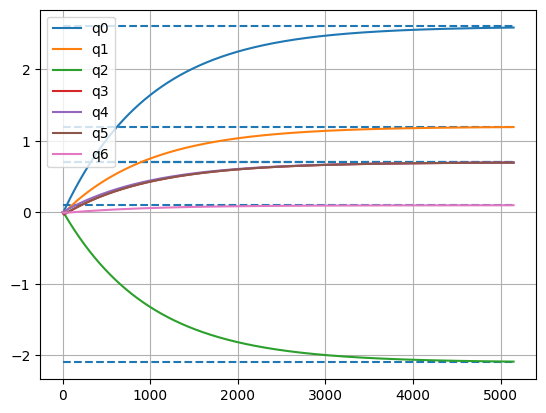

In [8]:
import matplotlib.pyplot as plt

history_q = np.array(history_q)

plt.hlines(q_des, 0, len(history_q), linestyles="dashed")
plt.plot(history_q, label=["q" + str(i) for i in range(7)])
plt.grid()
plt.legend()
plt.show()

## Robust Sliding Mode control of fully-actuated systems

The main assumptions are:
- system parameters are not completely known
- disturbance $\delta(t)$ is not given


The system dynamics with disturbance is as follows:

$$
\mathbf{M}(\mathbf{q})\ddot{\mathbf{q}} + \mathbf{h}(\mathbf{q},\dot{\mathbf{q}}) + \delta(\mathbf{q}, \dot{\mathbf{q}}, t) = \mathbf{u}
$$

Denoting operator $\hat{(\cdot)}$ as estimation of our paramters, the following control is used:


$$
\begin{cases}
\mathbf{u} = \hat{\mathbf{M}}(\mathbf{q})\mathbf{v} + \hat{\mathbf{h}}(\mathbf{q},\dot{\mathbf{q}}) \\
\mathbf{v} = \ddot{\mathbf{q}}_d + \mathbf{\Lambda}\dot{\tilde{\mathbf{q}}} + \mathbf{v}_s \\
\mathbf{v}_s = \rho \frac{\mathbf{s}}{\|\mathbf{s}\|} \\
\mathbf{s} = \dot{\tilde{\mathbf{q}}} + \mathbf{\Lambda} \tilde{\mathbf{q}}
\end{cases}
$$

where $\ddot{\mathbf{q}}_d$ is a desired acceleration; $\mathbf{\Lambda}$ is a positive definite gain matrix that regulates the rate of convergence. 

$$
\rho= \frac{k\hat{\mathbf{M}}^{-1}}{\sigma_{max}}
$$

In [9]:
mujoco.mj_inverse(model, data)
inertia_matrix = np.zeros((nv,nv))
mujoco.mj_fullM(model, inertia_matrix, data.qM.copy() )

_, sigma_max, _ = np.linalg.svd(inertia_matrix)
max(sigma_max)

4.970125870832876

In [10]:
mujoco.mj_resetData(model, data)  # Reset state and time.
# setup simulation

data.qpos = np.array([2.4,2.4,0.5,0.6,0.8,0.9, 0.0])

q_des = np.array([2.6,1.2,-2.1,0.9,-0.3,0.7, -0.7])
dq_des = np.array([0.,0.,0.,0.,0.,0.,0.])
ddq_des = np.array([0.,0.,0.,0.,0.,0.,0.])

Lambda = np.eye(7)*50

k = 200


mujoco.mj_inverse(model, data)
inertia_matrix = np.zeros((nv,nv))
mujoco.mj_fullM(model, inertia_matrix, data.qM.copy() )

_, sigmas, _ = np.linalg.svd(inertia_matrix)
sigma_max = 5 #max(sigmas)

torque_motor = ActuatorMotor()

for actuator_id in range(model.nu):
    update_actuator(model, actuator_id, torque_motor)

duration = 20.3  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
history_q = []
history_u = []
frames = []
while data.time < duration:
    q = data.qpos.copy()
    dq = data.qvel.copy()

    mujoco.mj_step(model, data) 
    
    inertia_matrix = np.zeros((nv,nv))
    mujoco.mj_fullM(model, inertia_matrix, data.qM.copy() )
    h = data.qfrc_bias.copy()

    M_hat = 0.8*inertia_matrix
    h_hat = 1.1*h

    err_q = (q_des-q)
    err_dq = (dq_des-dq)
    s = err_dq + Lambda @ err_q
    s_norm = np.linalg.norm(s)
    
    rho = (k/sigma_max)*np.linalg.inv(M_hat)
    
    vs = rho@s/s_norm

    v = ddq_des + Lambda @ err_dq + vs
    data.ctrl[:] = M_hat@v + h_hat 
    history_q.append(data.qpos.copy())
    history_u.append(data.ctrl[:].copy())
    
    # Do your control here!
    # data.qpos, data.qvel 
    # 
    # print(data.time, data.qpos, data.qvel)
    # if len(frames) < data.time * framerate:
    #     renderer.update_scene(data)
    #     pixels = renderer.render()
    #     frames.append(pixels)
        
# media.show_video(frames, fps=framerate)

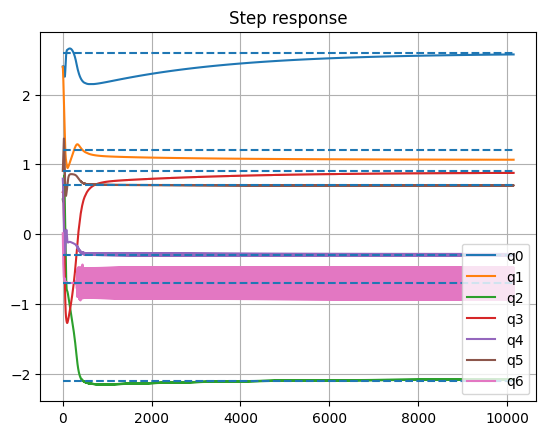

In [11]:
history_q = np.array(history_q)


plt.plot(history_q, label=["q" + str(i) for i in range(7)])
plt.hlines(q_des, 0, len(history_q), linestyles="dashed")
plt.grid()
plt.legend()
plt.title('Step response')
plt.show()

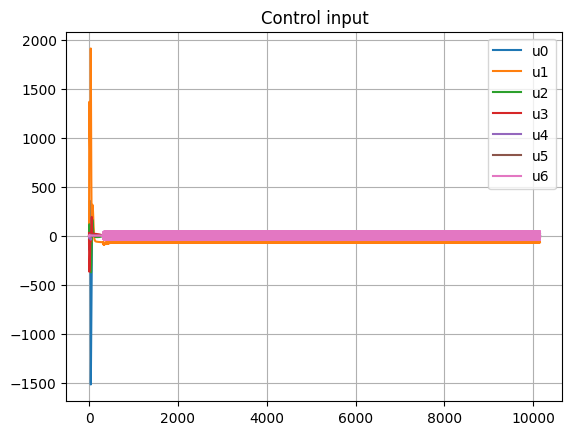

In [12]:
plt.plot(history_u, label=["u" + str(i) for i in range(7)])
plt.grid()
plt.legend()
plt.title('Control input')
plt.show()

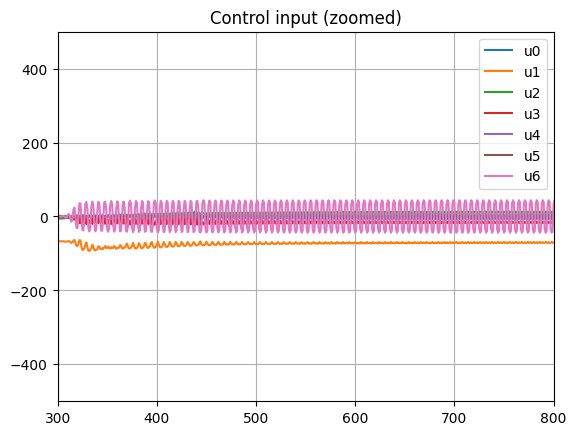

In [13]:
plt.plot(history_u, label=["u" + str(i) for i in range(7)])
plt.xlim(300,800)
plt.ylim(-500,500)
plt.grid()
plt.legend()
plt.title('Control input (zoomed)')
plt.show()

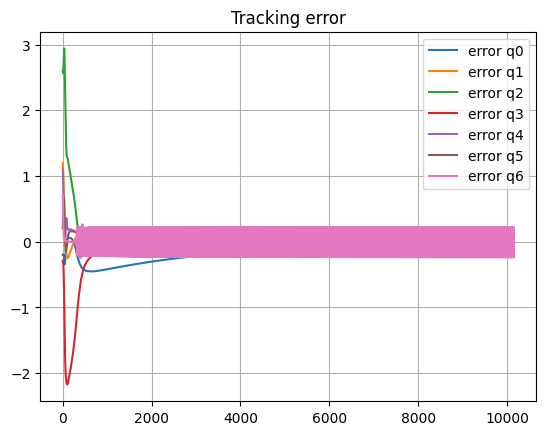

In [14]:
plt.plot(history_q-q_des, label=["error q" + str(i) for i in range(7)])
plt.grid()
plt.legend()
plt.title('Tracking error')
plt.show()

### Smoothening the control

Sliding mode control tries strictly keep the system on sliding surface $\mathbf{s}=0$ which leads to the so caled "chattering" on control (the control rapidly changes).

The following function smoothes the control:
$$
\mathbf{v}_s = 
\begin{cases}
\rho \frac{\mathbf{s}}{\|\mathbf{s}\|}, \quad \|\mathbf{s}\| >\epsilon\\
\rho \frac{\mathbf{s}}{\epsilon}, \quad \|\mathbf{s}\| \leq\epsilon
\end{cases}
$$

In [15]:
mujoco.mj_resetData(model, data)  # Reset state and time.
# setup simulation

data.qpos = np.array([2.4,2.4,0.5,0.6,0.8,0.9, 0.0])

q_des = np.array([2.6,1.2,-2.1,0.9,-0.3,0.7, -0.7])
dq_des = np.array([0.,0.,0.,0.,0.,0.,0.])
ddq_des = np.array([0.,0.,0.,0.,0.,0.,0.])

Lambda = np.eye(7)*50

k = 200

eps = 130.8

mujoco.mj_inverse(model, data)
inertia_matrix = np.zeros((nv,nv))
mujoco.mj_fullM(model, inertia_matrix, data.qM.copy() )

_, sigmas, _ = np.linalg.svd(inertia_matrix)
sigma_max = 5 #max(sigmas)

torque_motor = ActuatorMotor()

for actuator_id in range(model.nu):
    update_actuator(model, actuator_id, torque_motor)

duration = 20.3  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
history_q = []
history_u = []
frames = []
while data.time < duration:
    q = data.qpos.copy()
    dq = data.qvel.copy()

    mujoco.mj_step(model, data) 
    
    inertia_matrix = np.zeros((nv,nv))
    mujoco.mj_fullM(model, inertia_matrix, data.qM.copy() )
    h = data.qfrc_bias.copy()

    M_hat = 0.8*inertia_matrix
    h_hat = 1.1*h

    err_q = (q_des-q)
    err_dq = (dq_des-dq)
    s = err_dq + Lambda @ err_q
    s_norm = np.linalg.norm(s)
    
    rho = (k/sigma_max)*np.linalg.inv(M_hat)
    
    if s_norm<=eps:
        vs = rho@s/eps
    else:
        vs = rho@s/s_norm

    v = ddq_des + Lambda @ err_dq + vs
    data.ctrl[:] = M_hat@v + h_hat 
    history_q.append(data.qpos.copy())
    history_u.append(data.ctrl[:].copy())
    
    # Do your control here!
    # data.qpos, data.qvel 
    # 
    # print(data.time, data.qpos, data.qvel)
    # if len(frames) < data.time * framerate:
    #     renderer.update_scene(data)
    #     pixels = renderer.render()
    #     frames.append(pixels)
        
# media.show_video(frames, fps=framerate)

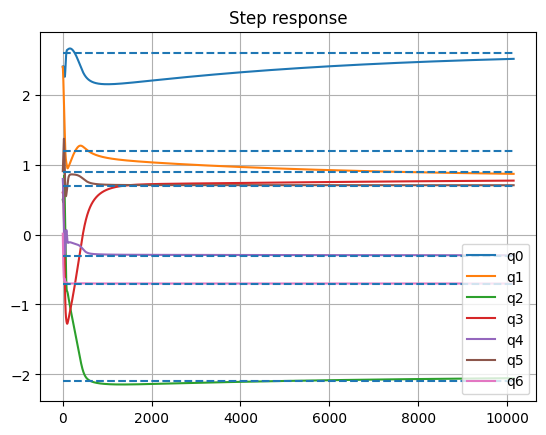

In [16]:
history_q = np.array(history_q)


plt.plot(history_q, label=["q" + str(i) for i in range(7)])
plt.hlines(q_des, 0, len(history_q), linestyles="dashed")
plt.grid()
plt.legend()
plt.title('Step response')
plt.show()

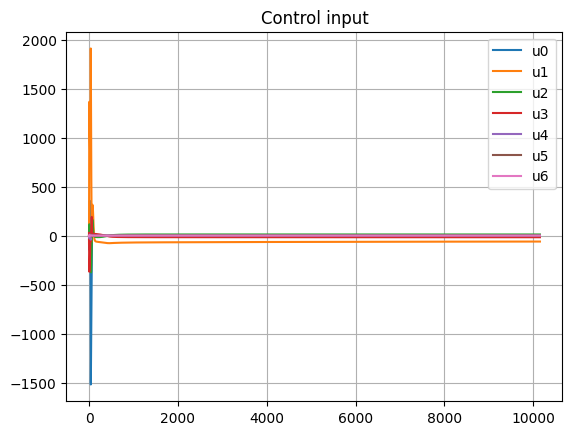

In [17]:
plt.plot(history_u, label=["u" + str(i) for i in range(7)])
plt.grid()
plt.legend()
plt.title('Control input')
plt.show()

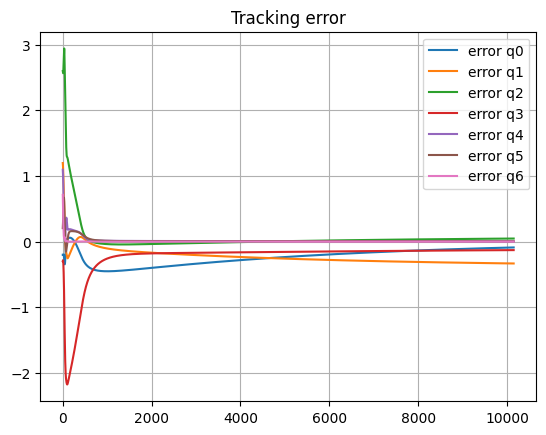

In [18]:
plt.plot(history_q-q_des, label=["error q" + str(i) for i in range(7)])
plt.grid()
plt.legend()
plt.title('Tracking error')
plt.show()

### External disturbance

External disturbance is defined in the dunction `mjdata.qfrc_applied`. The control is left without change, and eventually, we should see that even under some external disturbance control still works.

In [19]:
mujoco.mj_resetData(model, data)  # Reset state and time.
# setup simulation

data.qpos = np.array([2.4,2.4,0.5,0.6,0.8,0.9, 0.0])

q_des = np.array([2.6,1.2,-2.1,0.9,-0.3,0.7, -0.7])
dq_des = np.array([0.,0.,0.,0.,0.,0.,0.])
ddq_des = np.array([0.,0.,0.,0.,0.,0.,0.])

Lambda = np.eye(7)*50

k = 200

eps = 130.8

mujoco.mj_inverse(model, data)
inertia_matrix = np.zeros((nv,nv))
mujoco.mj_fullM(model, inertia_matrix, data.qM.copy() )

_, sigmas, _ = np.linalg.svd(inertia_matrix)
sigma_max = 5 #max(sigmas)

torque_motor = ActuatorMotor()

for actuator_id in range(model.nu):
    update_actuator(model, actuator_id, torque_motor)

duration = 20.3  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
history_q = []
history_u = []
frames = []
while data.time < duration:
    q = data.qpos.copy()
    dq = data.qvel.copy()

    data.qfrc_applied = np.sin(data.time)
    mujoco.mj_step(model, data) 
    
    inertia_matrix = np.zeros((nv,nv))
    mujoco.mj_fullM(model, inertia_matrix, data.qM.copy() )
    h = data.qfrc_bias.copy()

    M_hat = 0.8*inertia_matrix
    h_hat = 1.1*h

    err_q = (q_des-q)
    err_dq = (dq_des-dq)
    s = err_dq + Lambda @ err_q
    s_norm = np.linalg.norm(s)
    
    rho = (k/sigma_max)*np.linalg.inv(M_hat)
    
    if s_norm<=eps:
        vs = rho@s/eps
    else:
        vs = rho@s/s_norm

    v = ddq_des + Lambda @ err_dq + vs
    data.ctrl[:] = M_hat@v + h_hat 
    history_q.append(data.qpos.copy())
    history_u.append(data.ctrl[:].copy())
    
    # Do your control here!
    # data.qpos, data.qvel 
    # 
    # print(data.time, data.qpos, data.qvel)
    # if len(frames) < data.time * framerate:
    #     renderer.update_scene(data)
    #     pixels = renderer.render()
    #     frames.append(pixels)
        
# media.show_video(frames, fps=framerate)

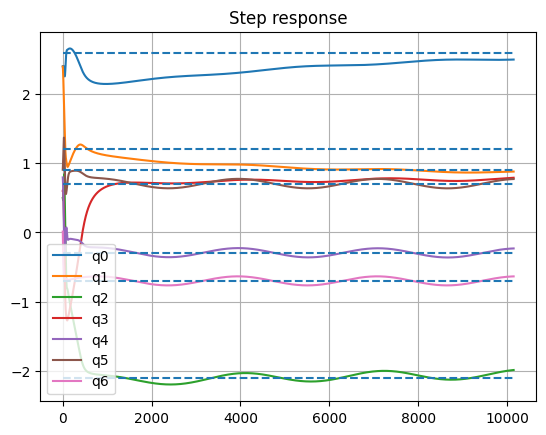

In [20]:
history_q = np.array(history_q)


plt.plot(history_q, label=["q" + str(i) for i in range(7)])
plt.hlines(q_des, 0, len(history_q), linestyles="dashed")
plt.grid()
plt.legend()
plt.title('Step response')
plt.show()

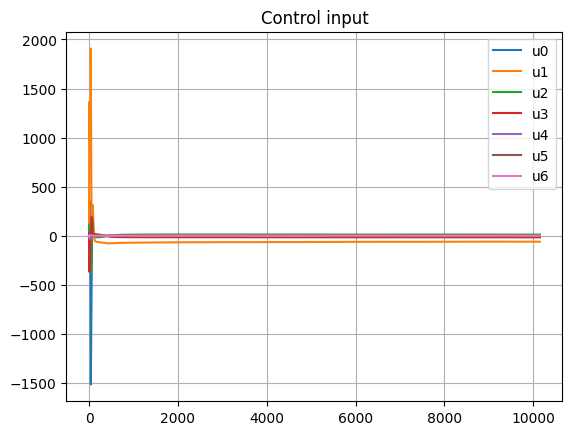

In [21]:
plt.plot(history_u, label=["u" + str(i) for i in range(7)])
plt.grid()
plt.legend()
plt.title('Control input')
plt.show()

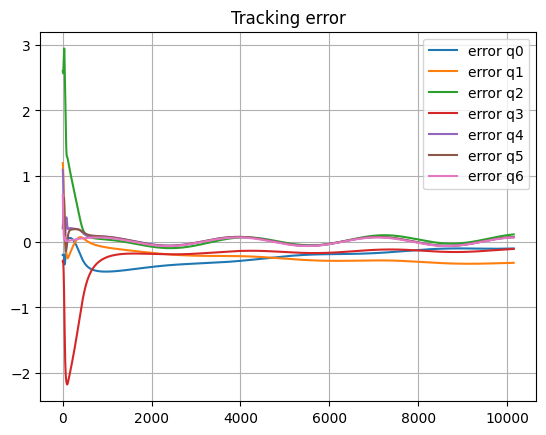

In [22]:
plt.plot(history_q-q_des, label=["error q" + str(i) for i in range(7)])
plt.grid()
plt.legend()
plt.title('Tracking error')
plt.show()